# 初始化

In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from IPython.display import display, clear_output
from collections import deque
import time
import warnings
warnings.filterwarnings('ignore')

# skrl 導入
from skrl.agents.torch.ppo import PPO, PPO_DEFAULT_CONFIG
from skrl.envs.wrappers.torch import wrap_env
from skrl.memories.torch import RandomMemory
from skrl.models.torch import DeterministicMixin, GaussianMixin, Model
from skrl.resources.preprocessors.torch import RunningStandardScaler

# 設定設備
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 使用設備: {device}")
if device.type == 'cuda':
    print(f"   GPU 名稱: {torch.cuda.get_device_name(0)}")
    print(f"   GPU 記憶體: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Matplotlib 設定
%matplotlib inline
plt.rcParams['figure.figsize'] = [14, 10]
plt.rcParams['font.size'] = 10

🚀 使用設備: cuda
   GPU 名稱: NVIDIA GeForce RTX 4060 Laptop GPU
   GPU 記憶體: 8.59 GB


# 模型定義

In [2]:
class PolicyNetwork(GaussianMixin, Model):
    """
    策略網路 (Actor) - 輸出動作的高斯分佈
    針對 BipedalWalker 優化的網路架構
    觀察空間: 24 維 | 動作空間: 4 維（連續）
    """
    def __init__(self, observation_space, action_space, device, 
                 clip_actions=False, clip_log_std=True, 
                 min_log_std=-20, max_log_std=2, reduction="sum"):
        Model.__init__(self, observation_space, action_space, device)
        GaussianMixin.__init__(self, clip_actions, clip_log_std, min_log_std, max_log_std, reduction)
        
        # 網路架構 (針對 BipedalWalker 優化)
        self.net = nn.Sequential(
            nn.Linear(self.num_observations, 256),
            nn.Tanh(),
            nn.Linear(256, 256),
            nn.Tanh(),
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, self.num_actions)
        )
        
        # 可學習的標準差參數
        self.log_std_parameter = nn.Parameter(torch.zeros(self.num_actions))
        
        # 初始化權重
        self._init_weights()
    
    def _init_weights(self):
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=np.sqrt(2))
                nn.init.constant_(m.bias, 0)
        # 輸出層使用較小的初始化
        nn.init.orthogonal_(list(self.net)[-1].weight, gain=0.01)
    
    def compute(self, inputs, role):
        return self.net(inputs["states"]), self.log_std_parameter, {}


class ValueNetwork(DeterministicMixin, Model):
    """
    價值網路 (Critic) - 估計狀態價值函數 V(s)
    """
    def __init__(self, observation_space, action_space, device, clip_actions=False):
        Model.__init__(self, observation_space, action_space, device)
        DeterministicMixin.__init__(self, clip_actions)
        
        self.net = nn.Sequential(
            nn.Linear(self.num_observations, 256),
            nn.Tanh(),
            nn.Linear(256, 256),
            nn.Tanh(),
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=np.sqrt(2))
                nn.init.constant_(m.bias, 0)
    
    def compute(self, inputs, role):
        return self.net(inputs["states"]), {}


print("✅ 神經網路模型已定義 (BipedalWalker 優化版)")
print(f"   觀察維度: 24")
print(f"   動作維度: 4 (連續)")

✅ 神經網路模型已定義 (BipedalWalker 優化版)
   觀察維度: 24
   動作維度: 4 (連續)


# 多視窗訓練

In [ ]:
class MultiWindowTrainingVisualizer:
    """
    多視窗訓練可視化器
    在 JupyterLab 中顯示多個 BipedalWalker 環境的即時渲染與訓練曲線
    """
    def __init__(self, num_envs=4, env_id="BipedalWalker-v3", hardcore=False):
        self.num_envs = num_envs
        self.env_id = env_id
        self.hardcore = hardcore
        
        # 訓練統計
        self.episode_rewards = []
        self.episode_lengths = []
        self.policy_losses = []
        self.value_losses = []
        self.entropy_values = []
        self.current_rewards = [0.0] * num_envs
        self.current_lengths = [0] * num_envs
        
        # 成功追蹤（BipedalWalker 獎勵 > 300 視為成功）
        self.success_count = 0
        
        # 創建渲染環境
        self.render_envs = []
        for i in range(num_envs):
            try:
                env = gym.make(env_id, hardcore=hardcore, render_mode="rgb_array")
                self.render_envs.append(env)
            except Exception as e:
                print(f"⚠️ 創建渲染環境 {i} 失敗: {e}")
        
        self._setup_figure()
        
    def _setup_figure(self):
        """設定圖形佈局"""
        self.fig = plt.figure(figsize=(16, 12))
        gs = GridSpec(3, 4, figure=self.fig, hspace=0.35, wspace=0.25)
        
        # 環境渲染視窗 (1行4個環境)
        self.ax_envs = []
        self.env_images = []
        
        for i in range(4):
            ax = self.fig.add_subplot(gs[0, i])
            ax.set_title(f"Walker {i+1}", fontsize=11, fontweight='bold')
            ax.axis('off')
            # BipedalWalker 渲染尺寸
            img = ax.imshow(np.zeros((400, 600, 3), dtype=np.uint8))
            self.ax_envs.append(ax)
            self.env_images.append(img)
        
        # 獎勵曲線
        self.ax_reward = self.fig.add_subplot(gs[1, :2])
        self.ax_reward.set_title("Training Reward", fontsize=12, fontweight='bold')
        self.ax_reward.set_xlabel("Episode")
        self.ax_reward.set_ylabel("Reward")
        self.ax_reward.axhline(y=300, color='green', linestyle='--', alpha=0.7, label='success criterion (300)')
        self.ax_reward.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
        self.ax_reward.grid(True, alpha=0.3)
        self.reward_line, = self.ax_reward.plot([], [], 'b-', alpha=0.4, label='Episode Reward')
        self.avg_reward_line, = self.ax_reward.plot([], [], 'r-', linewidth=2, label='Avg Reward (50 ep)')
        self.ax_reward.legend(loc='lower right', fontsize=9)
        
        # Episode 長度曲線
        self.ax_length = self.fig.add_subplot(gs[1, 2:])
        self.ax_length.set_title("Episode Length", fontsize=12, fontweight='bold')
        self.ax_length.set_xlabel("Episode")
        self.ax_length.set_ylabel("Steps")
        self.ax_length.grid(True, alpha=0.3)
        self.length_line, = self.ax_length.plot([], [], 'g-', alpha=0.4)
        self.avg_length_line, = self.ax_length.plot([], [], 'm-', linewidth=2, label='Avg Length (50 ep)')
        self.ax_length.legend(loc='upper left', fontsize=9)
        
        # 損失曲線
        self.ax_loss = self.fig.add_subplot(gs[2, :2])
        self.ax_loss.set_title("Training Loss", fontsize=12, fontweight='bold')
        self.ax_loss.set_xlabel("Update Step")
        self.ax_loss.set_ylabel("Loss")
        self.ax_loss.grid(True, alpha=0.3)
        self.policy_loss_line, = self.ax_loss.plot([], [], 'b-', label='Policy Loss', alpha=0.8)
        self.value_loss_line, = self.ax_loss.plot([], [], 'orange', label='Value Loss', alpha=0.8)
        self.ax_loss.legend(loc='upper right', fontsize=9)
        
        # 統計資訊文字框
        self.ax_info = self.fig.add_subplot(gs[2, 2:])
        self.ax_info.axis('off')
        self.info_text = self.ax_info.text(0.05, 0.95, '', transform=self.ax_info.transAxes,
                                           fontsize=10, verticalalignment='top',
                                           fontfamily='monospace',
                                           bbox=dict(boxstyle='round', facecolor='#f0f0f0', alpha=0.9))
        
        plt.tight_layout()
    
    def reset_render_envs(self):
        """重置所有渲染環境"""
        observations = []
        for env in self.render_envs:
            obs, _ = env.reset()
            observations.append(obs)
        return observations
    
    def step_render_envs(self, actions):
        """執行渲染環境的一步"""
        frames = []
        for i, env in enumerate(self.render_envs):
            if i < len(actions):
                action = actions[i]
                if isinstance(action, torch.Tensor):
                    action = action.cpu().numpy()
                # 確保動作是正確的形狀
                if hasattr(action, '__len__') and len(action.shape) > 1:
                    action = action.flatten()[:4]
                try:
                    obs, reward, terminated, truncated, info = env.step(action)
                    frame = env.render()
                    frames.append(frame)
                    
                    self.current_rewards[i] += reward
                    self.current_lengths[i] += 1
                    
                    if terminated or truncated:
                        ep_reward = self.current_rewards[i]
                        self.episode_rewards.append(ep_reward)
                        self.episode_lengths.append(self.current_lengths[i])
                        
                        # 成功計數
                        if ep_reward >= 300:
                            self.success_count += 1
                        
                        self.current_rewards[i] = 0.0
                        self.current_lengths[i] = 0
                        env.reset()
                        
                except Exception as e:
                    frames.append(np.zeros((400, 600, 3), dtype=np.uint8))
                    env.reset()
            else:
                frames.append(np.zeros((400, 600, 3), dtype=np.uint8))
        
        return frames
    
    def update_display(self, frames, step, policy_loss=None, value_loss=None):
        """更新顯示"""
        # 更新環境渲染
        for i, (img, frame) in enumerate(zip(self.env_images, frames)):
            if frame is not None and len(frame.shape) == 3:
                img.set_data(frame)
        
        # 更新損失
        if policy_loss is not None:
            self.policy_losses.append(policy_loss)
        if value_loss is not None:
            self.value_losses.append(value_loss)
        
        # 更新獎勵曲線
        if self.episode_rewards:
            x = list(range(len(self.episode_rewards)))
            self.reward_line.set_data(x, self.episode_rewards)
            
            # 計算移動平均
            if len(self.episode_rewards) >= 5:
                window = min(50, len(self.episode_rewards))
                avg_rewards = []
                for i in range(len(self.episode_rewards)):
                    start = max(0, i - window + 1)
                    avg_rewards.append(np.mean(self.episode_rewards[start:i+1]))
                self.avg_reward_line.set_data(x, avg_rewards)
            
            self.ax_reward.relim()
            self.ax_reward.autoscale_view()
        
        # 更新長度曲線
        if self.episode_lengths:
            x = list(range(len(self.episode_lengths)))
            self.length_line.set_data(x, self.episode_lengths)
            
            if len(self.episode_lengths) >= 5:
                window = min(50, len(self.episode_lengths))
                avg_lengths = []
                for i in range(len(self.episode_lengths)):
                    start = max(0, i - window + 1)
                    avg_lengths.append(np.mean(self.episode_lengths[start:i+1]))
                self.avg_length_line.set_data(x, avg_lengths)
            
            self.ax_length.relim()
            self.ax_length.autoscale_view()
        
        # 更新損失曲線
        if self.policy_losses:
            x = list(range(len(self.policy_losses)))
            self.policy_loss_line.set_data(x, self.policy_losses)
            self.ax_loss.relim()
            self.ax_loss.autoscale_view()
        
        if self.value_losses:
            x = list(range(len(self.value_losses)))
            self.value_loss_line.set_data(x, self.value_losses)
            self.ax_loss.relim()
            self.ax_loss.autoscale_view()
        
        # 更新統計資訊
        info_str = self._get_info_string(step)
        self.info_text.set_text(info_str)
        
        # 顯示
        display(self.fig)
        clear_output(wait=True)
    
    def _get_info_string(self, step):
        """生成統計資訊字串"""
        avg_reward = np.mean(self.episode_rewards[-50:]) if self.episode_rewards else 0
        max_reward = max(self.episode_rewards) if self.episode_rewards else 0
        min_reward = min(self.episode_rewards[-50:]) if self.episode_rewards else 0
        avg_length = np.mean(self.episode_lengths[-50:]) if self.episode_lengths else 0
        success_rate = (self.success_count / len(self.episode_rewards) * 100) if self.episode_rewards else 0
        
        # 進度條
        total_target = 500000  # 目標步數
        progress = min(step / total_target, 1.0)
        bar_length = 20
        filled = int(bar_length * progress)
        bar = '█' * filled + '░' * (bar_length - filled)
        
        info = f"""

[BipedalWalker PPO]
progress: [{bar}] {progress*100:5.1f}% 
total steps:          {step:>12,}         
total Episodes:       {len(self.episode_rewards):>12,}
success count (≥300): {self.success_count:>12,}
success rate:         {success_rate:>11.1f}
average reward (50ep):{avg_reward:>12.2f}
highest reward:       {max_reward:>12.2f}
lowest reward (50ep): {min_reward:>12.2f}
average length (50ep):{avg_length:>12.1f}
----------------------------------------
device: {str(device):>28}
enviroment: {'BipedalWalker-v3':>28}
        """
        return info
    
    def close(self):
        """關閉所有環境"""
        for env in self.render_envs:
            env.close()
        plt.close(self.fig)


print("✅ 多視窗可視化器已定義 (BipedalWalker 版本)")

✅ 多視窗可視化器已定義 (BipedalWalker 版本)


# 定義訓練

In [4]:
# ============================================
# 訓練參數設定 (針對 BipedalWalker 優化)
# ============================================
NUM_ENVS = 8                    # 並行環境數量（BipedalWalker 較輕量，可以更多）
ENV_ID = "BipedalWalker-v3"     # 環境 ID
HARDCORE = False                # 是否使用困難模式
TOTAL_TIMESTEPS = 500_000       # 總訓練步數
ROLLOUT_STEPS = 2048            # 每次收集的步數
UPDATE_EPOCHS = 10              # 每次更新的訓練輪數
MINI_BATCH_SIZE = 64            # Mini-batch 大小
LEARNING_RATE = 3e-4            # 學習率
GAMMA = 0.99                    # 折扣因子
GAE_LAMBDA = 0.95               # GAE lambda
CLIP_RANGE = 0.2                # PPO clip 範圍
VF_COEF = 0.5                   # 價值函數係數
ENT_COEF = 0.001                # 熵係數（BipedalWalker 用較小值）
VISUALIZE_FREQ = 30             # 可視化頻率

print("=" * 55)
print("🚶 BipedalWalker-v3 PPO 訓練配置")
print("=" * 55)
print(f"  環境:             {ENV_ID} {'(Hardcore)' if HARDCORE else '(Normal)'}")
print(f"  並行環境數量:     {NUM_ENVS}")
print(f"  總訓練步數:       {TOTAL_TIMESTEPS:,}")
print(f"  Rollout 步數:     {ROLLOUT_STEPS}")
print(f"  更新輪數:         {UPDATE_EPOCHS}")
print(f"  Mini-batch 大小:  {MINI_BATCH_SIZE}")
print(f"  學習率:           {LEARNING_RATE}")
print(f"  折扣因子 (γ):     {GAMMA}")
print(f"  GAE λ:            {GAE_LAMBDA}")
print(f"  Clip 範圍:        {CLIP_RANGE}")
print(f"  熵係數:           {ENT_COEF}")
print("=" * 55)

# ============================================
# 創建向量化環境
# ============================================
from gymnasium.vector import SyncVectorEnv

def make_env(env_id, idx, hardcore=False):
    def _init():
        env = gym.make(env_id, hardcore=hardcore)
        return env
    return _init

# 創建並行訓練環境
vec_env = SyncVectorEnv([make_env(ENV_ID, i, HARDCORE) for i in range(NUM_ENVS)])
print(f"\n✅ 已創建 {NUM_ENVS} 個並行訓練環境")
print(f"   觀察空間: {vec_env.single_observation_space} (24維)")
print(f"   動作空間: {vec_env.single_action_space} (4維連續)")

# 包裝環境供 skrl 使用
wrapped_env = wrap_env(vec_env, wrapper="gymnasium")

# ============================================
# 創建記憶緩衝區
# ============================================
memory = RandomMemory(memory_size=ROLLOUT_STEPS, num_envs=NUM_ENVS, device=device)
print(f"✅ 已創建記憶緩衝區 (大小: {ROLLOUT_STEPS} x {NUM_ENVS} = {ROLLOUT_STEPS * NUM_ENVS:,})")

# ============================================
# 實例化神經網路模型
# ============================================
models = {}
models["policy"] = PolicyNetwork(
    wrapped_env.observation_space, 
    wrapped_env.action_space, 
    device
)
models["value"] = ValueNetwork(
    wrapped_env.observation_space, 
    wrapped_env.action_space, 
    device
)

# 計算模型參數數量
policy_params = sum(p.numel() for p in models["policy"].parameters())
value_params = sum(p.numel() for p in models["value"].parameters())
print(f"\n✅ 已創建神經網路模型")
print(f"   Policy 網路參數: {policy_params:,}")
print(f"   Value 網路參數:  {value_params:,}")
print(f"   總參數數量:      {policy_params + value_params:,}")

# ============================================
# 配置 PPO 代理
# ============================================
ppo_config = PPO_DEFAULT_CONFIG.copy()
ppo_config["rollouts"] = ROLLOUT_STEPS
ppo_config["learning_epochs"] = UPDATE_EPOCHS
ppo_config["mini_batches"] = MINI_BATCH_SIZE
ppo_config["discount_factor"] = GAMMA
ppo_config["lambda"] = GAE_LAMBDA
ppo_config["learning_rate"] = LEARNING_RATE
ppo_config["learning_rate_scheduler"] = None
ppo_config["random_timesteps"] = 0
ppo_config["grad_norm_clip"] = 0.5
ppo_config["ratio_clip"] = CLIP_RANGE
ppo_config["value_clip"] = CLIP_RANGE
ppo_config["clip_predicted_values"] = True
ppo_config["entropy_loss_scale"] = ENT_COEF
ppo_config["value_loss_scale"] = VF_COEF
ppo_config["kl_threshold"] = 0
ppo_config["state_preprocessor"] = RunningStandardScaler
ppo_config["state_preprocessor_kwargs"] = {"size": wrapped_env.observation_space, "device": device}
ppo_config["value_preprocessor"] = RunningStandardScaler
ppo_config["value_preprocessor_kwargs"] = {"size": 1, "device": device}
ppo_config["experiment"]["write_interval"] = 100
ppo_config["experiment"]["checkpoint_interval"] = 5000

# 創建 PPO 代理
agent = PPO(
    models=models,
    memory=memory,
    cfg=ppo_config,
    observation_space=wrapped_env.observation_space,
    action_space=wrapped_env.action_space,
    device=device
)

print(f"\n✅ PPO 代理已創建並載入到 {device}")
print(f"\n💡 BipedalWalker 任務說明:")
print(f"   - 目標: 控制雙足機器人走到終點")
print(f"   - 成功標準: 總獎勵 ≥ 300")
print(f"   - 動作: 4個連續值 (兩條腿的髖關節和膝關節)")

🚶 BipedalWalker-v3 PPO 訓練配置
  環境:             BipedalWalker-v3 (Normal)
  並行環境數量:     8
  總訓練步數:       500,000
  Rollout 步數:     2048
  更新輪數:         10
  Mini-batch 大小:  64
  學習率:           0.0003
  折扣因子 (γ):     0.99
  GAE λ:            0.95
  Clip 範圍:        0.2
  熵係數:           0.001


[skrl:INFO] Environment wrapper: gymnasium



✅ 已創建 8 個並行訓練環境
   觀察空間: Box([-3.1415927 -5.        -5.        -5.        -3.1415927 -5.
 -3.1415927 -5.        -0.        -3.1415927 -5.        -3.1415927
 -5.        -0.        -1.        -1.        -1.        -1.
 -1.        -1.        -1.        -1.        -1.        -1.       ], [3.1415927 5.        5.        5.        3.1415927 5.        3.1415927
 5.        5.        3.1415927 5.        3.1415927 5.        5.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.       ], (24,), float32) (24維)
   動作空間: Box(-1.0, 1.0, (4,), float32) (4維連續)
✅ 已創建記憶緩衝區 (大小: 2048 x 8 = 16,384)

✅ 已創建神經網路模型
   Policy 網路參數: 105,608
   Value 網路參數:  105,217
   總參數數量:      210,825

✅ PPO 代理已創建並載入到 cuda

💡 BipedalWalker 任務說明:
   - 目標: 控制雙足機器人走到終點
   - 成功標準: 總獎勵 ≥ 300
   - 動作: 4個連續值 (兩條腿的髖關節和膝關節)


# 定義訓練循環

In [5]:
def train_with_visualization():
    """
    帶有多視窗可視化的 BipedalWalker 訓練循環
    """
    print("\n" + "=" * 60)
    print("🚀 開始訓練 BipedalWalker-v3 (PPO + CUDA)")
    print("=" * 60)
    
    # 創建可視化器（顯示4個環境）
    visualizer = MultiWindowTrainingVisualizer(num_envs=4, env_id=ENV_ID, hardcore=HARDCORE)
    
    # 初始化
    agent.init()
    states, infos = wrapped_env.reset()
    visualizer.reset_render_envs()
    
    total_steps = 0
    update_count = 0
    start_time = time.time()
    best_avg_reward = -float('inf')
    
    # 用於追蹤每個環境的獎勵
    env_episode_rewards = [0.0] * NUM_ENVS
    env_episode_lengths = [0] * NUM_ENVS
    
    try:
        while total_steps < TOTAL_TIMESTEPS:
            # ==========================================
            # 收集 Rollout 數據
            # ==========================================
            for rollout_step in range(ROLLOUT_STEPS):
                # 獲取動作
                with torch.no_grad():
                    actions = agent.act(states, timestep=total_steps, timesteps=TOTAL_TIMESTEPS)[0]
                
                # 執行動作
                next_states, rewards, terminated, truncated, infos = wrapped_env.step(actions)
                dones = terminated | truncated
                
                # 記錄經驗
                agent.record_transition(
                    states=states,
                    actions=actions,
                    rewards=rewards,
                    next_states=next_states,
                    terminated=terminated,
                    truncated=truncated,
                    infos=infos,
                    timestep=total_steps,
                    timesteps=TOTAL_TIMESTEPS
                )
                
                # 追蹤獎勵
                rewards_np = rewards.cpu().numpy() if isinstance(rewards, torch.Tensor) else rewards
                dones_np = dones.cpu().numpy() if isinstance(dones, torch.Tensor) else dones
                
                for i in range(NUM_ENVS):
                    r = float(rewards_np[i]) if hasattr(rewards_np, '__getitem__') else float(rewards_np)
                    d = bool(dones_np[i]) if hasattr(dones_np, '__getitem__') else bool(dones_np)
                    
                    env_episode_rewards[i] += r
                    env_episode_lengths[i] += 1
                    
                    if d:
                        visualizer.episode_rewards.append(env_episode_rewards[i])
                        visualizer.episode_lengths.append(env_episode_lengths[i])
                        
                        # 成功計數
                        if env_episode_rewards[i] >= 300:
                            visualizer.success_count += 1
                        
                        env_episode_rewards[i] = 0.0
                        env_episode_lengths[i] = 0
                
                states = next_states
                total_steps += NUM_ENVS
                
                # 更新可視化（每隔一定步數）
                if rollout_step % VISUALIZE_FREQ == 0:
                    # 獲取渲染幀（只用前4個環境的動作）
                    actions_for_render = actions[:4].cpu().numpy() if isinstance(actions, torch.Tensor) else actions[:4]
                    frames = visualizer.step_render_envs(actions_for_render)
                    
                    # 獲取損失值
                    policy_loss = visualizer.policy_losses[-1] if visualizer.policy_losses else None
                    value_loss = visualizer.value_losses[-1] if visualizer.value_losses else None
                    
                    visualizer.update_display(
                        frames=frames,
                        step=total_steps,
                        policy_loss=policy_loss,
                        value_loss=value_loss
                    )
            
            # ==========================================
            # 更新代理
            # ==========================================
            with torch.no_grad():
                value = agent.models["value"].act({"states": states}, role="value")[0]
                agent.memory.set_tensor_by_name("values", value)
            
            # 執行 PPO 更新
            result = agent.post_interaction(timestep=total_steps, timesteps=TOTAL_TIMESTEPS)
            
            # 嘗試獲取損失值
            try:
                if hasattr(agent, '_track_data') and agent._track_data:
                    if "Policy loss" in agent._track_data:
                        visualizer.policy_losses.append(float(agent._track_data["Policy loss"]))
                    if "Value loss" in agent._track_data:
                        visualizer.value_losses.append(float(agent._track_data["Value loss"]))
            except:
                pass
            
            update_count += 1
            
            # 重置記憶
            agent.memory.reset()
            
            # 計算並顯示進度
            elapsed = time.time() - start_time
            fps = total_steps / elapsed if elapsed > 0 else 0
            progress = total_steps / TOTAL_TIMESTEPS * 100
            
            # 檢查是否達到新的最佳成績
            if visualizer.episode_rewards:
                current_avg = np.mean(visualizer.episode_rewards[-100:])
                if current_avg > best_avg_reward:
                    best_avg_reward = current_avg
                    if best_avg_reward >= 300:
                        print(f"\n🎉 達到成功標準! 平均獎勵: {best_avg_reward:.2f}")
            
            if update_count % 5 == 0:
                avg_reward = np.mean(visualizer.episode_rewards[-50:]) if visualizer.episode_rewards else 0
                print(f"\r進度: {progress:5.1f}% | 步數: {total_steps:,}/{TOTAL_TIMESTEPS:,} | "
                      f"FPS: {fps:.0f} | 平均獎勵: {avg_reward:.2f} | 成功: {visualizer.success_count}", end="")
    
    except KeyboardInterrupt:
        print("\n\n⚠️ 訓練被使用者中斷")
    
    finally:
        # 關閉可視化器
        visualizer.close()
        
        # 訓練結束統計
        total_time = time.time() - start_time
        print("\n\n" + "=" * 60)
        print("🏁 訓練完成!")
        print("=" * 60)
        print(f"  總訓練時間:     {total_time/60:.2f} 分鐘")
        print(f"  總步數:         {total_steps:,}")
        print(f"  總 Episodes:    {len(visualizer.episode_rewards)}")
        print(f"  總更新次數:     {update_count}")
        print(f"  平均 FPS:       {total_steps/total_time:.0f}")
        if visualizer.episode_rewards:
            print(f"  最終平均獎勵:   {np.mean(visualizer.episode_rewards[-50:]):.2f}")
            print(f"  最高獎勵:       {max(visualizer.episode_rewards):.2f}")
            print(f"  成功次數:       {visualizer.success_count}")
            print(f"  成功率:         {visualizer.success_count/len(visualizer.episode_rewards)*100:.1f}%")
        print("=" * 60)
        
    return agent, visualizer

# 開始訓練

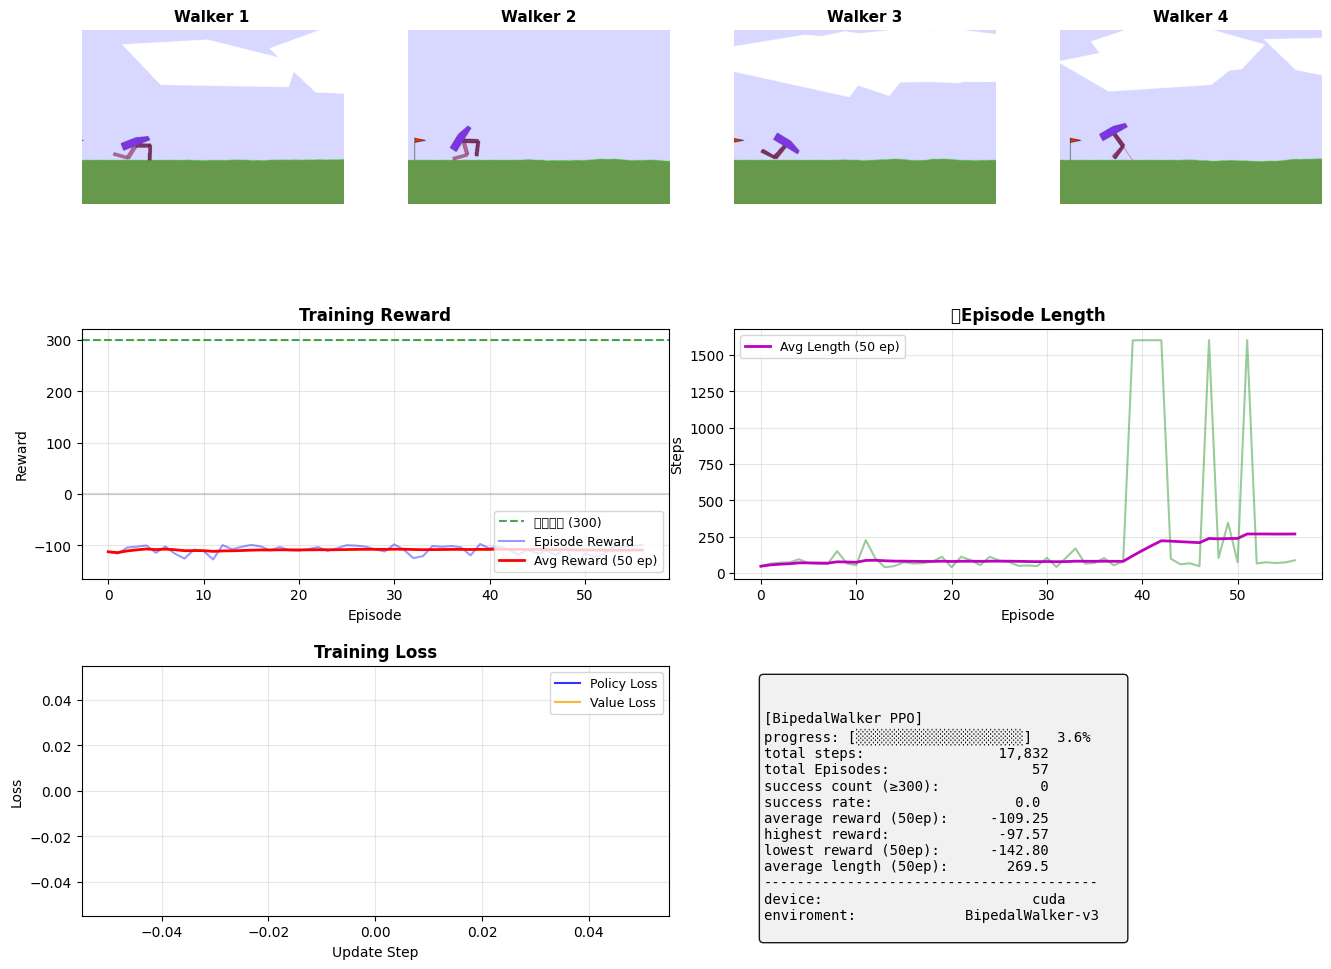

In [ ]:
# 開始帶可視化的訓練
trained_agent, viz = train_with_visualization()